In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import glob
import scipy

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.filters import sobel
from skimage.color import rgb2gray
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import *
from keras.layers.merge import concatenate
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

%matplotlib inline

C:\Python\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# make config

rows = 64
cols = 192
train_path = "train"
label_path = "labels"
img_type = "jpg"
test_path = "test"
npy_path = "npydata"

# Low-level segmentation with superpixel algorithms

In [3]:
def create_data(data_path_img, npy_path, rows, cols, alg, segments = None, img_type = "jpg"):   
    imgs = glob.glob("data\\" + data_path_img + "\\*." + img_type)
    img_count = len(imgs)
    i = 0
    imgs_data = np.ndarray((img_count, rows, cols, 1))
    for img_name in imgs:
        img = load_img(img_name)
        img = img_as_float(img)
        if type(segments) == type(None):
            segments = segments_creation(img, alg)
        segment_mean = scipy.ndimage.measurements.mean(img[:,:,0], segments, range(250))
        img = segment_mean[segments]
        imgs_data[i] = np.expand_dims(img, axis = 2)
        if i % 10 == 0:
            print('Done: {0}/{1} images'.format(i, img_count))
        i += 1
    print('Created.')
    np.save("data\\" + npy_path + '\\imgs_' + data_path_img + '.npy', imgs_data)
    print('Saving to .npy files done.')
    return segments

In [4]:
def segments_creation(img, alg):
    if (alg == "felzenszwalb"):
        return felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    elif (alg == "quickshift"):
        return quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    elif (alg == "watershed"):
        gradient = sobel(rgb2gray(img))
        return watershed(gradient, markers=250, compactness=0.001)
    else:
        return slic(img, n_segments=250, compactness=10, sigma=1)

In [5]:
def load_data(data_path, npy_path, process_colors = False):
    imgs = np.load("data\\" + npy_path + '\\imgs_' + data_path + '.npy')
    imgs = imgs.astype('float32')
    imgs /= 255
    if (process_colors):
        imgs[imgs > 0.5] = 1
        imgs[imgs <= 0.5] = 0
    return imgs

In [6]:
algs = ["felzenszwalb", "slic", "quickshift", "watershed"]

for alg in algs:
    segments = create_data(train_path, npy_path + "_" + alg, rows, cols, alg)
    segments = create_data(label_path, npy_path + "_" + alg, rows, cols, alg, segments)
    segments = create_data(test_path, npy_path + "_" + alg, rows, cols, alg)

C:\Python\lib\site-packages\scipy\ndimage\measurements.py:639: RuntimeWarning: invalid value encountered in true_divide
  return sum / numpy.asanyarray(count).astype(numpy.float)


Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30/35 images
Created.
Saving to .npy files done.
Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30/35 images
Created.
Saving to .npy files done.
Done: 0/4 images
Created.
Saving to .npy files done.
Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30/35 images
Created.
Saving to .npy files done.
Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30/35 images
Created.
Saving to .npy files done.
Done: 0/4 images
Created.
Saving to .npy files done.
Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30/35 images
Created.
Saving to .npy files done.
Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30/35 images
Created.
Saving to .npy files done.
Done: 0/4 images
Created.
Saving to .npy files done.
Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30/35 images
Created.
Saving to .npy files done.
Done: 0/35 images
Done: 10/35 images
Done: 20/35 images
Done: 30

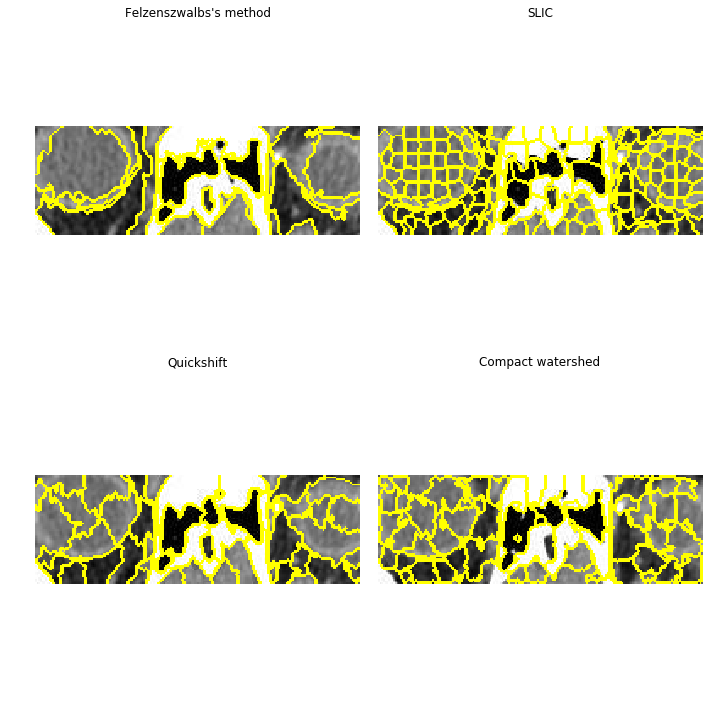

In [19]:
img = load_img ("data\\train\\2.jpg")
img = img_as_float(img)

segments_fz = felzenszwalb(img, scale=200, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=200, compactness=10, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=100, compactness=0.001)

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

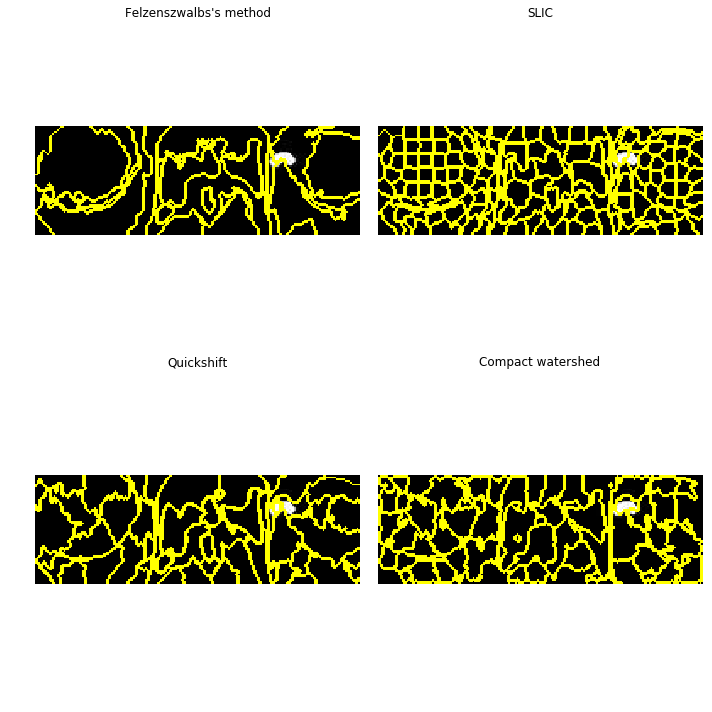

In [20]:
img = load_img ("data\\labels\\2.jpg")
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# U-net

In [22]:
def load_data(data_path, npy_path, process_colors = False):
    imgs = np.load("data\\" + npy_path + '\\imgs_' + data_path + '.npy')
    imgs = imgs.astype('float32')
    imgs /= 255
    
    imgs /= np.max(np.abs(imgs))

    if (process_colors):
        imgs[imgs > 0.5] = 1
        imgs[imgs <= 0.5] = 0
    return imgs

In [35]:
def build_UNet(rows, cols, k_size=3):
    inputs = Input((rows, cols, 1))
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu', trainable=False)(inputs)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(pool1)
    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)
    
    """""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """""""""""" """""" """""" """""" """""" """"""

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(up3)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu', trainable=False)(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(up4)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu', trainable=False)(merged4)

    conv10 = Conv2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid', trainable=False)(conv9)

    output = conv10
    model = Model(inputs, output)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy', dice_coef])
    return model

In [41]:
def save_results(imgs, alg):
    i = 1
    for img in imgs:
            img = array_to_img(img)
            img.save("data\\results\\" + alg + "_" + str(i) +".jpg")   
            i += 1

In [37]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [39]:
def train(train_path, test_path, label_path, npy_path, alg, rows, cols):
    imgs_train = load_data(train_path, npy_path + "_" + alg)
    imgs_test = load_data(test_path, npy_path  + "_" + alg)
    imgs_mask_train = load_data(label_path, npy_path  + "_" + alg, True)
    
    model = build_UNet(rows, cols)
    model.load_weights('trained_model.hdf5')
    weights_list = model.get_weights()
    
    model_checkpoint = ModelCheckpoint('weights_' + alg + '.hdf5', monitor='loss',verbose=1, save_best_only=True)
    model.fit(imgs_train, imgs_mask_train, batch_size = 4, nb_epoch = 10, verbose = 1, validation_split=0.2,
              callbacks=[model_checkpoint])
    
    imgs_mask_test = model.predict(imgs_test, batch_size = 4, verbose = 1)
    save_results(imgs_mask_test, alg)   

In [42]:
algs = ["felzenszwalb", "slic", "quickshift", "watershed"]

for alg in algs:
    train(train_path, test_path, label_path, npy_path, alg, rows, cols)

C:\Python\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 28 samples, validate on 7 samples
Epoch 1/10
28/28 [==============================] - 22s 802ms/step - loss: 0.0078 - acc: 0.9988 - dice_coef: 0.1315 - val_loss: 1.6152e-04 - val_acc: 1.0000 - val_dice_coef: 0.3581

Epoch 00001: loss improved from inf to 0.00777, saving model to weights_felzenszwalb.hdf5
Epoch 2/10
28/28 [==============================] - 23s 818ms/step - loss: 0.0060 - acc: 0.9991 - dice_coef: 0.1955 - val_loss: 1.2411e-04 - val_acc: 1.0000 - val_dice_coef: 0.4092

Epoch 00002: loss improved from 0.00777 to 0.00604, saving model to weights_felzenszwalb.hdf5
Epoch 3/10
28/28 [==============================] - 24s 854ms/step - loss: 0.0058 - acc: 0.9991 - dice_coef: 0.2349 - val_loss: 1.1049e-04 - val_acc: 1.0000 - val_dice_coef: 0.4339

Epoch 00003: loss improved from 0.00604 to 0.00577, saving model to weights_felzenszwalb.hdf5
Epoch 4/10
28/28 [==============================] - 24s 840ms/step - loss: 0.0053 - acc: 0.9991 - dice_coef: 0.2541 - val_loss: 1.053

28/28 [==============================] - 25s 903ms/step - loss: 0.0036 - acc: 0.9994 - dice_coef: 0.2398 - val_loss: 1.6745e-04 - val_acc: 1.0000 - val_dice_coef: 0.3330

Epoch 00010: loss improved from 0.00377 to 0.00355, saving model to weights_quickshift.hdf5
4/4 [==============================] - 2s 465ms/step
Train on 28 samples, validate on 7 samples
Epoch 1/10
28/28 [==============================] - 28s 985ms/step - loss: 0.0422 - acc: 0.9947 - dice_coef: 0.0217 - val_loss: 0.0279 - val_acc: 0.9964 - val_dice_coef: 0.0191

Epoch 00001: loss improved from inf to 0.04223, saving model to weights_watershed.hdf5
Epoch 2/10
28/28 [==============================] - 24s 874ms/step - loss: 0.0385 - acc: 0.9951 - dice_coef: 0.0274 - val_loss: 0.0271 - val_acc: 0.9964 - val_dice_coef: 0.0196

Epoch 00002: loss improved from 0.04223 to 0.03852, saving model to weights_watershed.hdf5
Epoch 3/10
28/28 [==============================] - 24s 861ms/step - loss: 0.0366 - acc: 0.9951 - dice_coef